In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

In [2]:
## Signal processing variables.
raw_signal = np.array([])
filtered = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

# Peak detection variables.
fiducial_mark_val_i = np.array([])
fiducial_mark_idx = np.array([])

## Peak thresholding variables.
qrs_peak_i = np.array([])
noise_peak_i = np.array([])

## Integrated signal detection and thresholding params.
spk_i = 0.0 
npk_i = 0.0 
threshold_i_1 = 0.0
threshold_i_2 = 0.0 

## Moving-window integration params.
integration_window = 3

## Tool methods.
def butter_bandpass_filter(data, lowcut, highcut, signal_freq, order):
    """Constructs signal filter."""
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

In [3]:
## Load and clean data.
with open("data/pulse1.csv") as f:
    content = f.readlines()
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))
    
## Signal filtering - pass band 0-12 Hz.
filtered_signal = butter_bandpass_filter(raw_signal, lowcut=0.0, highcut=12.0, signal_freq=84.0, order=1)

## Derivative original - provides QRS slope info.
differentiated_signal = np.diff(filtered_signal)

## Squaring.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration.
integrated_signal = np.convolve(squared_signal, np.ones((integration_window,)) / integration_window)

## Fiducial mark - peak detection - integrated signal - original.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val_i = np.append(fiducial_mark_val_i, integrated_signal[peak_index])
    
## Thresholding detect peaks - integrated signal.
for peak_idx, peak_val_i in zip(fiducial_mark_idx, fiducial_mark_val_i):
    if peak_val_i > threshold_i_1:
        spk_i = 0.125 * peak_val_i + 0.875 * spk_i
        qrs_peak_i = np.append(qrs_peak_i, peak_idx)
        
    else:
        npk_i = 0.125 * peak_val_i + 0.875 * npk_i
        noise_peak_i = np.append(noise_peak_i, peak_idx)
        
    threshold_i_1 = npk_i + 0.25 * (spk_i - npk_i)
    threshold_i_2 = 0.5 * threshold_i_1
    

(0.0, 344.0, 0.0, 3.4506354331)

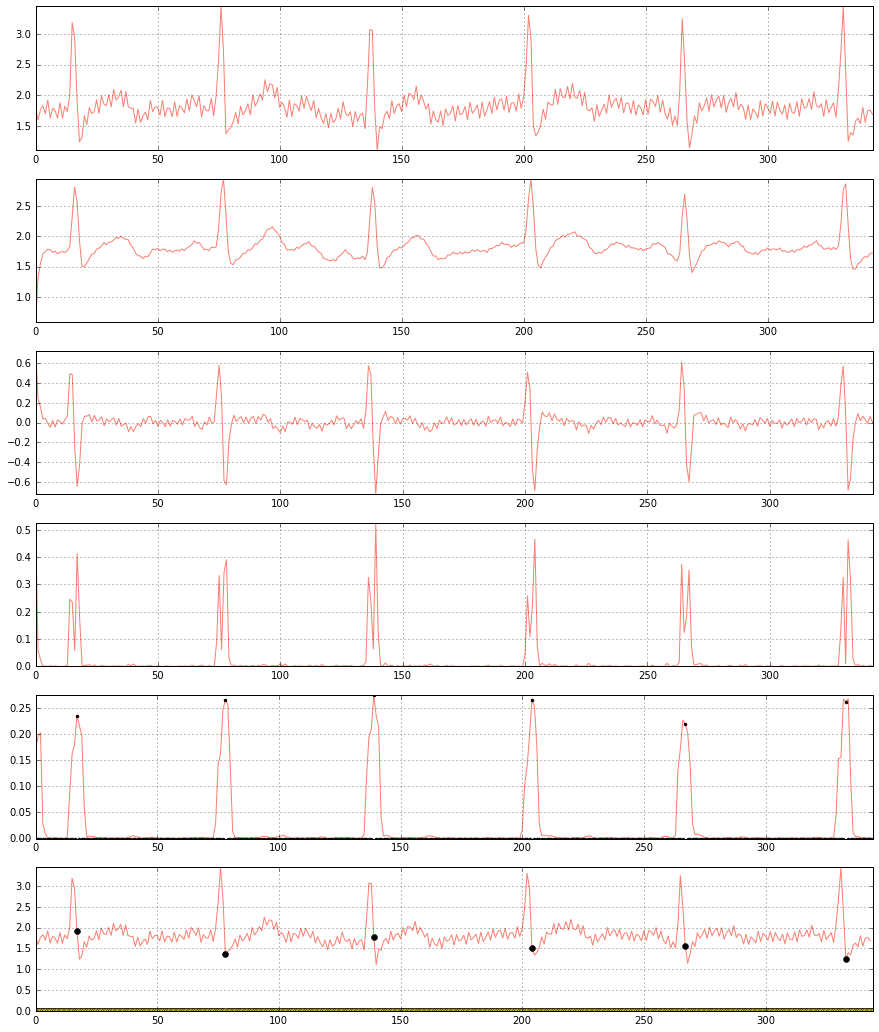

In [4]:
## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(611)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(612)
plt.plot(filtered_signal, label="Filtered signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(613)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(614)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication_i = [0] * len(integrated_signal)
for peak_idx_i, peak_val_i in zip(fiducial_mark_idx, fiducial_mark_val_i):
    fiducial_mark_indication_i[int(peak_idx_i)] = peak_val_i
plt.subplot(615)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication_i, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication_i = [0] * len(integrated_signal)
for peak_i in qrs_peak_i:
    qrs_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]
noise_peak_indication_i = [0] * len(integrated_signal)
for peak_i in noise_peak_i:
    noise_peak_indication_i[int(peak_i)] = raw_signal[int(peak_i)]
plt.subplot(616)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication_i, 'ko')
plt.plot(noise_peak_indication_i, 'yo')
plt.grid(True)
plt.axis("tight")
